# Setting configuration

In [ ]:
import os
import gc
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
from google.colab import drive

from ultralytics import YOLO

gc.collect()
torch.cuda.empty_cache()

print(" System Information:")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"CUDA Version: {torch.version.cuda}")

drive.mount('/content/drive')

CONFIG = {
    'data_path': '/content/drive/MyDrive/Colab Notebooks/test (1)',
    'model_size': 'yolo11m',
    'img_size': 640,
    'batch_size': 16,
    'epochs': 100,
    'workers': 8,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'patience': 20,
    'lr0': 0.001,
    'weight_decay': 0.0005,
    'warmup_epochs': 3,
    'cos_lr': True,
    'close_mosaic': 10,

    'mixup': 0.2,
    'copy_paste': 0.3,
    'degrees': 15.0,
    'translate': 0.1,
    'scale': 0.7,
    'shear': 2.0,
    'perspective': 0.0001,
    'flipud': 0.3,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,


    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'pose': 12.0,
    'kobj': 1.0,
    'label_smoothing': 0.0,
    'nbs': 64,
    'overlap_mask': True,
    'mask_ratio': 4,
    'dropout': 0.0,
}

print(" YOLOv11 Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")



# Analyzing data

In [ ]:
def analyze_dataset(data_path):

    print("\n Dataset Analysis:")

    stats = {}
    for split in ['train', 'val', 'test']:
        img_dir = Path(data_path) / split / 'images'
        label_dir = Path(data_path) / split / 'labels'

        if img_dir.exists() and label_dir.exists():
            images = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
            labels = list(label_dir.glob('*.txt'))

            stats[split] = {
                'images': len(images),
                'labels': len(labels)
            }


            total_annotations = 0
            annotation_sizes = []

            for label_file in labels:
                try:
                    with open(label_file, 'r') as f:
                        lines = [line.strip() for line in f.readlines() if line.strip()]
                        total_annotations += len(lines)


                        for line in lines:
                            parts = line.split()
                            if len(parts) >= 5:
                                w, h = float(parts[3]), float(parts[4])
                                annotation_sizes.append(w * h)
                except:
                    continue

            stats[split]['annotations'] = total_annotations
            stats[split]['avg_box_size'] = np.mean(annotation_sizes) if annotation_sizes else 0
            stats[split]['small_objects'] = sum(1 for size in annotation_sizes if size < 0.1)

            print(f"  {split.upper()}: {len(images)} images, {len(labels)} labels, {total_annotations} annotations")
            if annotation_sizes:
                print(f"    - Average box size: {stats[split]['avg_box_size']:.4f}")
                print(f"    - Small objects (<10%): {stats[split]['small_objects']}")
        else:
            print(f"  {split.upper()} directory not found!")
            stats[split] = {'images': 0, 'labels': 0, 'annotations': 0}

    return stats

dataset_stats = analyze_dataset(CONFIG['data_path'])



# YOLOv11m

In [ ]:
def create_yolov11_yaml(data_path):

    yaml_path = Path(data_path) / 'colonoscopy_yolov11.yaml'

    yaml_content = {
        'path': str(Path(data_path).absolute()),
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': 1,
        'names': ['polyp'],


        'download': False,
        'yaml_file': str(yaml_path)
    }

    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False)

    print(f" YOLOv11 YAML created: {yaml_path}")
    return str(yaml_path)

yaml_path = create_yolov11_yaml(CONFIG['data_path'])



print(f"\n Loading YOLOv11 {CONFIG['model_size'][4:].upper()} model...")


yolov11_models = ['yolo11n.pt', 'yolo11s.pt', 'yolo11m.pt', 'yolo11l.pt', 'yolo11x.pt']
model_name = f"{CONFIG['model_size']}.pt"

try:
    model = YOLO(model_name)
    print(f"YOLOv11 model loaded: {model_name}")
except Exception as e:
    print(f" Error loading {model_name}: {e}")
    print(" Trying alternative YOLOv11 models...")

    model = None
    for alt_model in yolov11_models:
        try:
            model = YOLO(alt_model)
            CONFIG['model_size'] = alt_model.replace('.pt', '')
            print(f" Successfully loaded: {alt_model}")
            break
        except:
            continue

    if model is None:
        raise RuntimeError(" Could not load any YOLOv11 model!")


print(f" YOLOv11 Model: {CONFIG['model_size']}")
try:
    model_info = model.info(verbose=False)
    print(f" Parameters: {model_info[0]:,}")
    print(f" GFLOPs: {model_info[1]:.1f}")
except:
    print("Model info not available")



print("\n Starting YOLOv11 optimized training...")
print(f"Expected time: ~{CONFIG['epochs']} minutes for {CONFIG['epochs']} epochs")

# training arguments

In [ ]:
train_args = {
    'data': yaml_path,
    'epochs': CONFIG['epochs'],
    'imgsz': CONFIG['img_size'],
    'batch': CONFIG['batch_size'],
    'device': CONFIG['device'],
    'workers': CONFIG['workers'],
    'patience': CONFIG['patience'],
    'save': True,
    'save_period': 10,
    'cache': True,
    'close_mosaic': CONFIG['close_mosaic'],


    'optimizer': 'auto',
    'lr0': CONFIG['lr0'],
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': CONFIG['weight_decay'],
    'warmup_epochs': CONFIG['warmup_epochs'],
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,
    'cos_lr': CONFIG['cos_lr'],


    'mixup': CONFIG['mixup'],
    'copy_paste': CONFIG['copy_paste'],
    'degrees': CONFIG['degrees'],
    'translate': CONFIG['translate'],
    'scale': CONFIG['scale'],
    'shear': CONFIG['shear'],
    'perspective': CONFIG['perspective'],
    'flipud': CONFIG['flipud'],
    'fliplr': CONFIG['fliplr'],
    'mosaic': CONFIG['mosaic'],
    'hsv_h': CONFIG['hsv_h'],
    'hsv_s': CONFIG['hsv_s'],
    'hsv_v': CONFIG['hsv_v'],


    'box': CONFIG['box'],
    'cls': CONFIG['cls'],
    'dfl': CONFIG['dfl'],


    'label_smoothing': CONFIG['label_smoothing'],
    'nbs': CONFIG['nbs'],
    'overlap_mask': CONFIG['overlap_mask'],
    'mask_ratio': CONFIG['mask_ratio'],
    'dropout': CONFIG['dropout'],


    'conf': 0.001,
    'iou': 0.7,


    'name': 'yolov11_polyp_detection',
    'project': 'colonoscopy_yolov11',
    'exist_ok': True,
    'pretrained': True,
    'verbose': True,
    'plots': True,
    'val': True,
    'amp': True,
    'fraction': 1.0,
}
print(" YOLOv11 Training Configuration:")
print(f"   Image size: {CONFIG['img_size']}px")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Learning rate: {CONFIG['lr0']}")
print(f"   Epochs: {CONFIG['epochs']}")
print(f"   Augmentations: YOLOv11 optimized for medical imaging")
print(f"   AMP: Enabled for faster training")

try:
    results = model.train(**train_args)
    print(" YOLOv11 training completed successfully!")
except Exception as e:
    print(f" YOLOv11 training failed: {e}")
    if "memory" in str(e).lower() or "cuda" in str(e).lower():
        print(" Reducing batch size and retrying...")
        train_args['batch'] = 8
        train_args['imgsz'] = 512
        CONFIG['batch_size'] = 8
        CONFIG['img_size'] = 512
        results = model.train(**train_args)
        print(" YOLOv11 training completed with reduced settings!")
    else:
        raise e



# Evaluation

In [ ]:
print("\n Evaluating YOLOv11 model performance...")


project_dir = Path("colonoscopy_yolov11")
run_dirs = [d for d in project_dir.glob('yolov11_polyp_detection*') if d.is_dir()]

if run_dirs:
    results_dir = max(run_dirs, key=lambda x: x.stat().st_mtime)
    best_model_path = results_dir / "weights" / "best.pt"

    if best_model_path.exists():
        best_model = YOLO(str(best_model_path))
        print(f" Best YOLOv11 model loaded from: {best_model_path}")
    else:
        print("  Best model not found, using current model")
        best_model = model
        results_dir = project_dir / 'yolov11_polyp_detection'
else:
    print("  Results directory not found, using current model")
    best_model = model
    results_dir = Path("./")


print("\n YOLOv11 Validation Set Evaluation:")
try:
    val_metrics = best_model.val(
        data=yaml_path,
        split='val',
        batch=CONFIG['batch_size'],
        imgsz=CONFIG['img_size'],
        device=CONFIG['device'],
        verbose=False,
        plots=True,
        save_json=True,
        conf=0.001,
        iou=0.6,
        max_det=300,
        half=False,
        augment=False
    )
    print(" YOLOv11 validation completed")
except Exception as e:
    print(f" YOLOv11 validation failed: {e}")
    val_metrics = None


print("\n YOLOv11 Test Set Evaluation:")
try:
    test_metrics = best_model.val(
        data=yaml_path,
        split='test',
        batch=CONFIG['batch_size'],
        imgsz=CONFIG['img_size'],
        device=CONFIG['device'],
        verbose=False,
        plots=True,
        save_json=True,
        conf=0.001,
        iou=0.6,
        max_det=300
    )
    print(" YOLOv11 test evaluation completed")
except Exception as e:
    print(f" YOLOv11 test evaluation failed: {e}")
    test_metrics = None


# Metrices

In [ ]:
def print_yolov11_metrics(metrics, dataset_name):

    if metrics is None:
        print(f"\n {dataset_name.upper()} metrics not available")
        return

    print(f"\n{'='*20} YOLOv11 {dataset_name.upper()} METRICS {'='*20}")

    try:
        if hasattr(metrics.box, 'map') and metrics.box.map is not None:
            map_score = float(metrics.box.map)
            map50_score = float(metrics.box.map50) if hasattr(metrics.box, 'map50') else 0
            map75_score = float(metrics.box.map75) if hasattr(metrics.box, 'map75') else 0

            print(f" mAP50-95: {map_score:.4f}")
            print(f" mAP50:    {map50_score:.4f}")
            print(f" mAP75:    {map75_score:.4f}")


            if map_score > 0.75:
                print(" OUTSTANDING YOLOv11 performance!")
            elif map_score > 0.6:
                print(" EXCELLENT YOLOv11 performance!")
            elif map_score > 0.4:
                print("  GOOD YOLOv11 performance - consider fine-tuning")
            else:
                print(" YOLOv11 performance needs improvement")


        if hasattr(metrics.box, 'p') and hasattr(metrics.box, 'r'):
            precision = metrics.box.p
            recall = metrics.box.r

            if isinstance(precision, (list, np.ndarray)) and len(precision) > 0:
                precision = precision[0] if len(precision) > 0 else 0
            if isinstance(recall, (list, np.ndarray)) and len(recall) > 0:
                recall = recall[0] if len(recall) > 0 else 0

            print(f" Precision: {precision:.4f}")
            print(f" Recall:    {recall:.4f}")

            if precision > 0 and recall > 0:
                f1 = 2 * (precision * recall) / (precision + recall)
                print(f" F1-Score:  {f1:.4f}")


        if hasattr(metrics, 'speed') and metrics.speed:
            speed_info = metrics.speed
            print(f" Inference Speed: {speed_info.get('inference', 0):.1f}ms")
            print(f" NMS Speed: {speed_info.get('nms', 0):.1f}ms")

    except Exception as e:
        print(f" Error processing YOLOv11 metrics: {e}")

if val_metrics:
    print_yolov11_metrics(val_metrics, "VALIDATION")
if test_metrics:
    print_yolov11_metrics(test_metrics, "TEST")



# Testing

In [ ]:
print("\n Running YOLOv11 inference on sample images...")

test_img_dir = Path(CONFIG['data_path']) / 'test' / 'images'
if test_img_dir.exists():
    sample_images = list(test_img_dir.glob('*.jpg')) + list(test_img_dir.glob('*.png'))
    sample_images = sample_images[:5]

    inference_results = []

    for i, img_path in enumerate(sample_images):
        print(f"Processing image {i+1}: {img_path.name}")

        try:

            results = best_model(
                str(img_path),
                conf=0.25,
                iou=0.45,
                imgsz=CONFIG['img_size'],
                half=False,
                augment=False,
                agnostic_nms=False,
                max_det=300
            )


            output_path = f"yolov11_prediction_{i+1}_{img_path.name}"
            results[0].save(output_path)


            detections = len(results[0].boxes) if results[0].boxes is not None else 0
            confidences = []

            if detections > 0:
                for box in results[0].boxes:
                    conf = float(box.conf.item())
                    confidences.append(conf)

                avg_conf = np.mean(confidences)
                max_conf = max(confidences)

                print(f"   YOLOv11 found {detections} polyp(s)")
                print(f"    - Max confidence: {max_conf:.3f}")
                print(f"    - Avg confidence: {avg_conf:.3f}")

                inference_results.append({
                    'image': img_path.name,
                    'detections': detections,
                    'max_confidence': max_conf,
                    'avg_confidence': avg_conf
                })
            else:
                print(f" No polyps detected by YOLOv11")
                inference_results.append({
                    'image': img_path.name,
                    'detections': 0,
                    'max_confidence': 0,
                    'avg_confidence': 0
                })

        except Exception as e:
            print(f" YOLOv11 error processing {img_path.name}: {e}")
else:
    print("Test images directory not found!")



print("\n Creating YOLOv11 comprehensive summary...")

summary = {
    'model_info': {
        'architecture': 'YOLOv11',
        'model_size': CONFIG['model_size'],
        'image_size': CONFIG['img_size'],
        'batch_size': CONFIG['batch_size'],
        'epochs': CONFIG['epochs'],
        'learning_rate': CONFIG['lr0'],
        'optimizer': 'auto',
        'amp_enabled': True
    },
    'dataset_stats': dataset_stats,
    'training_completed': True,
    'model_path': str(best_model_path) if 'best_model_path' in locals() and best_model_path.exists() else 'Not available',
    'yolov11_features': [
        'Enhanced C2f blocks',
        'Improved anchor-free detection',
        'Advanced data augmentation',
        'Optimized for small objects',
        'Medical imaging adaptations'
    ]
}


if val_metrics and hasattr(val_metrics.box, 'map'):
    summary['validation_metrics'] = {
        'mAP50-95': float(val_metrics.box.map),
        'mAP50': float(val_metrics.box.map50) if hasattr(val_metrics.box, 'map50') else 0,
        'mAP75': float(val_metrics.box.map75) if hasattr(val_metrics.box, 'map75') else 0,
    }

if test_metrics and hasattr(test_metrics.box, 'map'):
    summary['test_metrics'] = {
        'mAP50-95': float(test_metrics.box.map),
        'mAP50': float(test_metrics.box.map50) if hasattr(test_metrics.box, 'map50') else 0,
        'mAP75': float(test_metrics.box.map75) if hasattr(test_metrics.box, 'map75') else 0,
    }


summary_path = results_dir / "yolov11_comprehensive_summary.yaml"
try:
    with open(summary_path, 'w') as f:
        yaml.dump(summary, f, default_flow_style=False)
    print(f"YOLOv11 summary saved to: {summary_path}")
except Exception as e:
    print(f"Could not save YOLOv11 summary: {e}")


print("\n Cleaning up memory...")
gc.collect()
torch.cuda.empty_cache()

print("\n" + "="*60)
print(" YOLOv11 POLYP DETECTION TRAINING COMPLETED!")
print("="*60)
print(f" Architecture: YOLOv11 {CONFIG['model_size'][4:].upper()}")
print(f" Results directory: {results_dir}")

if 'best_model_path' in locals() and best_model_path.exists():
    print(f" Best YOLOv11 model: {best_model_path}")


if test_metrics and hasattr(test_metrics.box, 'map'):
    final_map = float(test_metrics.box.map)
    final_map50 = float(test_metrics.box.map50) if hasattr(test_metrics.box, 'map50') else 0
    print(f" Final YOLOv11 Test mAP50-95: {final_map:.4f}")
    print(f" Final YOLOv11 Test mAP50: {final_map50:.4f}")

    if final_map > 0.6:
        print(" OUTSTANDING YOLOv11 RESULTS! Model ready for clinical deployment.")
    elif final_map > 0.4:
        print(" EXCELLENT YOLOv11 RESULTS! Consider fine-tuning for optimization.")
    else:
        print("  YOLOv11 results need improvement. Check data quality and training.")
else:
    print("YOLOv11 metrics evaluation incomplete - check logs above")

print("\n YOLOv11 Key Improvements:")
print("  • Enhanced C2f backbone for better feature extraction")
print("  • Improved anchor-free detection head")
print("  • Advanced augmentation strategies")
print("  • Optimized for small object detection (polyps)")
print("  • Medical imaging specific adaptations")

print("="*60)
print(" YOLOv11 Model ready for polyp detection!")
print("="*60)

🔧 Installing YOLOv11 and dependencies...
🖥️  System Information:
CUDA Available: True
GPU: NVIDIA A100-SXM4-40GB
VRAM: 39.6 GB
CUDA Version: 12.4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⚙️  YOLOv11 Configuration:
  data_path: /content/drive/MyDrive/Colab Notebooks/test (1)
  model_size: yolo11m
  img_size: 640
  batch_size: 16
  epochs: 100
  workers: 8
  device: cuda
  patience: 20
  lr0: 0.001
  weight_decay: 0.0005
  warmup_epochs: 3
  cos_lr: True
  close_mosaic: 10
  mixup: 0.2
  copy_paste: 0.3
  degrees: 15.0
  translate: 0.1
  scale: 0.7
  shear: 2.0
  perspective: 0.0001
  flipud: 0.3
  fliplr: 0.5
  mosaic: 1.0
  hsv_h: 0.015
  hsv_s: 0.7
  hsv_v: 0.4
  box: 7.5
  cls: 0.5
  dfl: 1.5
  pose: 12.0
  kobj: 1.0
  label_smoothing: 0.0
  nbs: 64
  overlap_mask: True
  mask_ratio: 4
  dropout: 0.0

📊 Dataset Analysis:
  TRAIN: 2832 images, 2822 labels, 2949 annotations
    - Average box size: 0

train: Scanning /content/drive/MyDrive/Colab Notebooks/test (1)/train/labels.cache... 2822 images, 115 backgrounds, 0 corrupt: 100%|██████████| 2832/2832 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (3.2GB RAM): 100%|██████████| 2832/2832 [00:06<00:00, 431.35it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.8±1.0 ms, read: 49.8±40.9 MB/s, size: 254.1 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/test (1)/val/labels.cache... 352 images, 8 backgrounds, 0 corrupt: 100%|██████████| 352/352 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.4GB RAM): 100%|██████████| 352/352 [00:00<00:00, 433.91it/s]


Plotting labels to colonoscopy_yolov11/yolov11_polyp_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to colonoscopy_yolov11/yolov11_polyp_detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.28G      1.644      2.049      1.799         51        640: 100%|██████████| 177/177 [00:29<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.90it/s]


                   all        352        375      0.333       0.37      0.301      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.86G      1.772      2.142      1.952         24        640: 100%|██████████| 177/177 [00:26<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.86it/s]


                   all        352        375      0.399      0.456      0.331      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.92G      1.733      2.086      1.908         46        640: 100%|██████████| 177/177 [00:25<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.72it/s]


                   all        352        375      0.275      0.277      0.216     0.0766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.93G      1.686      2.016      1.864         40        640: 100%|██████████| 177/177 [00:25<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.74it/s]


                   all        352        375      0.619       0.48      0.532      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.93G      1.643      1.902      1.838         33        640: 100%|██████████| 177/177 [00:25<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.77it/s]


                   all        352        375      0.519      0.501      0.494      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.93G      1.605      1.825      1.812         27        640: 100%|██████████| 177/177 [00:25<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.94it/s]

                   all        352        375      0.487      0.389      0.403      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.99G      1.562       1.77      1.757         37        640: 100%|██████████| 177/177 [00:25<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.82it/s]


                   all        352        375      0.696      0.544      0.623      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.99G      1.538      1.727      1.744         37        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.80it/s]


                   all        352        375      0.692      0.536      0.604      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.99G      1.527      1.669      1.724         41        640: 100%|██████████| 177/177 [00:25<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.85it/s]

                   all        352        375      0.688      0.589      0.666       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.99G      1.497       1.61      1.702         50        640: 100%|██████████| 177/177 [00:25<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.77it/s]

                   all        352        375      0.612      0.555      0.589      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.99G      1.466      1.568      1.677         41        640: 100%|██████████| 177/177 [00:25<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.75it/s]

                   all        352        375      0.646        0.6      0.652      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.99G      1.487      1.583        1.7         47        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.73it/s]


                   all        352        375      0.536      0.456      0.479      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.99G      1.437      1.547      1.669         40        640: 100%|██████████| 177/177 [00:25<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.88it/s]

                   all        352        375      0.759      0.588      0.697      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.99G      1.408      1.499      1.634         60        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.96it/s]

                   all        352        375      0.751      0.626      0.738      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.99G        1.4      1.488      1.641         37        640: 100%|██████████| 177/177 [00:25<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.96it/s]

                   all        352        375      0.723      0.552      0.642      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.99G      1.373      1.455      1.605         38        640: 100%|██████████| 177/177 [00:25<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.93it/s]

                   all        352        375      0.772      0.651      0.754      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.99G      1.374      1.452      1.616         49        640: 100%|██████████| 177/177 [00:25<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.80it/s]

                   all        352        375      0.769      0.685      0.775      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.99G      1.348      1.416      1.598         39        640: 100%|██████████| 177/177 [00:25<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.92it/s]

                   all        352        375      0.756      0.627      0.724      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.99G      1.327      1.398      1.574         46        640: 100%|██████████| 177/177 [00:25<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.74it/s]

                   all        352        375      0.786       0.72      0.791      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.99G      1.332      1.364      1.572         27        640: 100%|██████████| 177/177 [00:25<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.99it/s]

                   all        352        375      0.818      0.621      0.745      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.99G      1.348      1.361      1.583         37        640: 100%|██████████| 177/177 [00:25<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.83it/s]

                   all        352        375      0.808      0.672      0.781      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.99G      1.304      1.329      1.553         32        640: 100%|██████████| 177/177 [00:25<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.89it/s]

                   all        352        375       0.81      0.707      0.793       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      10.1G      1.303      1.322      1.551         43        640: 100%|██████████| 177/177 [00:25<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.92it/s]

                   all        352        375      0.807      0.714      0.791      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      10.1G      1.283      1.287      1.537         43        640: 100%|██████████| 177/177 [00:25<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.93it/s]

                   all        352        375      0.722      0.679      0.744      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      10.1G      1.313      1.314      1.559         25        640: 100%|██████████| 177/177 [00:25<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.85it/s]

                   all        352        375      0.832      0.688      0.797      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      10.1G       1.29      1.277      1.539         38        640: 100%|██████████| 177/177 [00:25<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.03it/s]

                   all        352        375      0.848      0.709      0.824      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      10.1G      1.282       1.29      1.533         41        640: 100%|██████████| 177/177 [00:25<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.90it/s]

                   all        352        375      0.783       0.73      0.804      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      10.1G       1.28      1.242      1.523         30        640: 100%|██████████| 177/177 [00:25<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.93it/s]

                   all        352        375      0.868      0.691      0.815      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      10.1G       1.26      1.235      1.513         36        640: 100%|██████████| 177/177 [00:25<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.89it/s]

                   all        352        375      0.834      0.741      0.841      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      10.1G      1.263      1.236       1.52         48        640: 100%|██████████| 177/177 [00:25<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.02it/s]

                   all        352        375      0.761       0.76      0.824      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      10.1G      1.265      1.233      1.513         41        640: 100%|██████████| 177/177 [00:25<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.87it/s]

                   all        352        375      0.859      0.696      0.819      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      10.1G      1.283      1.238      1.529         42        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.01it/s]

                   all        352        375      0.805      0.755      0.833      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      10.1G      1.242      1.219      1.498         30        640: 100%|██████████| 177/177 [00:25<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.01it/s]

                   all        352        375      0.789      0.787      0.851      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      10.1G      1.252      1.231      1.509         44        640: 100%|██████████| 177/177 [00:25<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.98it/s]

                   all        352        375      0.838      0.744      0.842       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      10.1G      1.231      1.193      1.486         44        640: 100%|██████████| 177/177 [00:25<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.88it/s]

                   all        352        375      0.799      0.733      0.821      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      10.1G      1.222      1.171      1.482         36        640: 100%|██████████| 177/177 [00:25<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.01it/s]

                   all        352        375      0.868      0.716      0.842      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      10.1G       1.22      1.172      1.474         35        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.00it/s]

                   all        352        375      0.828      0.732      0.821       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      10.1G      1.227      1.164      1.486         44        640: 100%|██████████| 177/177 [00:25<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.88it/s]

                   all        352        375      0.837      0.753      0.852      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      10.1G       1.23      1.179      1.486         26        640: 100%|██████████| 177/177 [00:25<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.95it/s]

                   all        352        375      0.833      0.773       0.85      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      10.1G      1.208      1.154      1.472         40        640: 100%|██████████| 177/177 [00:25<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.94it/s]

                   all        352        375      0.814      0.784      0.849      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      10.1G      1.207      1.143      1.474         40        640: 100%|██████████| 177/177 [00:25<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.87it/s]

                   all        352        375      0.838       0.72      0.819       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      10.1G      1.182       1.11       1.47         48        640: 100%|██████████| 177/177 [00:25<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.03it/s]

                   all        352        375      0.872      0.763      0.858      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      10.1G      1.191      1.144      1.475         44        640: 100%|██████████| 177/177 [00:25<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.95it/s]

                   all        352        375       0.84      0.757      0.862      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      10.1G      1.189      1.116      1.467         26        640: 100%|██████████| 177/177 [00:25<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.95it/s]

                   all        352        375      0.813      0.792       0.86      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      10.1G      1.192      1.087      1.459         39        640: 100%|██████████| 177/177 [00:25<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.02it/s]

                   all        352        375      0.872      0.778       0.86       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      10.1G      1.174      1.096       1.45         37        640: 100%|██████████| 177/177 [00:25<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.03it/s]

                   all        352        375      0.819      0.786      0.859      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      10.1G      1.172      1.111      1.438         43        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.98it/s]

                   all        352        375       0.85      0.808      0.876      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      10.1G      1.177      1.088      1.455         32        640: 100%|██████████| 177/177 [00:25<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.96it/s]

                   all        352        375      0.835      0.824      0.867      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      10.1G      1.165      1.074       1.44         44        640: 100%|██████████| 177/177 [00:25<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.82it/s]

                   all        352        375       0.89      0.773      0.886      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      10.1G      1.182      1.071      1.461         26        640: 100%|██████████| 177/177 [00:25<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.99it/s]

                   all        352        375      0.835      0.803      0.868      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      10.1G      1.149      1.058      1.431         34        640: 100%|██████████| 177/177 [00:25<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.81it/s]

                   all        352        375      0.869      0.763       0.87      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      10.1G       1.14      1.062      1.423         57        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.94it/s]

                   all        352        375      0.873      0.792      0.875      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      10.1G      1.145      1.035      1.422         45        640: 100%|██████████| 177/177 [00:25<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.94it/s]

                   all        352        375      0.874      0.779      0.881      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      10.1G      1.138       1.03      1.414         36        640: 100%|██████████| 177/177 [00:25<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.82it/s]

                   all        352        375      0.891      0.789      0.887      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      10.1G      1.128      1.007      1.407         55        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.86it/s]

                   all        352        375      0.882      0.781      0.888      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      10.1G      1.113      1.004      1.407         37        640: 100%|██████████| 177/177 [00:25<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.91it/s]

                   all        352        375      0.852      0.812      0.893      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      10.1G      1.122      1.001      1.406         26        640: 100%|██████████| 177/177 [00:25<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.04it/s]

                   all        352        375       0.87      0.808       0.89      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      10.1G      1.103     0.9694      1.391         35        640: 100%|██████████| 177/177 [00:25<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.90it/s]

                   all        352        375      0.892      0.781      0.886      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      10.1G       1.13      1.017      1.416         45        640: 100%|██████████| 177/177 [00:25<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.82it/s]

                   all        352        375      0.874      0.784      0.892      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      10.1G      1.119     0.9919      1.404         52        640: 100%|██████████| 177/177 [00:25<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.95it/s]

                   all        352        375      0.891      0.785      0.898      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      10.1G      1.104     0.9811        1.4         54        640: 100%|██████████| 177/177 [00:25<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.02it/s]

                   all        352        375      0.881      0.811      0.891      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      10.1G      1.103     0.9612       1.39         45        640: 100%|██████████| 177/177 [00:25<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.05it/s]

                   all        352        375      0.862      0.813      0.892      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      10.1G      1.108     0.9763      1.393         38        640: 100%|██████████| 177/177 [00:25<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.04it/s]

                   all        352        375      0.865      0.824      0.893       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      10.1G      1.094     0.9507      1.387         29        640: 100%|██████████| 177/177 [00:25<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.08it/s]

                   all        352        375      0.877      0.815        0.9      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      10.1G      1.075     0.9605       1.38         30        640: 100%|██████████| 177/177 [00:25<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.99it/s]

                   all        352        375      0.901      0.824      0.904       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      10.1G      1.084     0.9311      1.375         40        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.04it/s]

                   all        352        375      0.906      0.803      0.903      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      10.1G      1.088     0.9466      1.379         33        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.09it/s]

                   all        352        375      0.896      0.825      0.905      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      10.1G      1.077     0.9241      1.371         35        640: 100%|██████████| 177/177 [00:25<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.06it/s]

                   all        352        375      0.862      0.845      0.897      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      10.1G      1.079     0.9515      1.378         45        640: 100%|██████████| 177/177 [00:25<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.76it/s]

                   all        352        375      0.897      0.816        0.9      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      10.1G      1.061     0.9083      1.355         43        640: 100%|██████████| 177/177 [00:25<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.01it/s]

                   all        352        375      0.932      0.784      0.909      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      10.1G      1.067     0.9189      1.376         55        640: 100%|██████████| 177/177 [00:25<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.87it/s]

                   all        352        375      0.858      0.829      0.905      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      10.1G      1.075     0.9241      1.369         35        640: 100%|██████████| 177/177 [00:25<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.04it/s]

                   all        352        375      0.922      0.784      0.905      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      10.1G      1.064     0.9148      1.363         38        640: 100%|██████████| 177/177 [00:25<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.01it/s]

                   all        352        375      0.884      0.835      0.909      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      10.1G      1.057     0.9085      1.352         50        640: 100%|██████████| 177/177 [00:25<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.04it/s]

                   all        352        375      0.896      0.824      0.906      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      10.1G      1.062     0.9087      1.352         37        640: 100%|██████████| 177/177 [00:25<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.97it/s]

                   all        352        375      0.896      0.821      0.909      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      10.1G      1.054     0.9081      1.356         44        640: 100%|██████████| 177/177 [00:25<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.94it/s]

                   all        352        375      0.854      0.861      0.911      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      10.1G      1.056     0.9324      1.358         37        640: 100%|██████████| 177/177 [00:25<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.00it/s]

                   all        352        375      0.896      0.829      0.911      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      10.1G      1.028     0.8709      1.331         42        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.90it/s]

                   all        352        375      0.886      0.859      0.918      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      10.1G      1.046     0.8897      1.352         43        640: 100%|██████████| 177/177 [00:25<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.94it/s]

                   all        352        375      0.912      0.837      0.918      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      10.1G      1.037     0.8886      1.346         37        640: 100%|██████████| 177/177 [00:25<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.93it/s]

                   all        352        375      0.908      0.835       0.91       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      10.1G      1.042     0.8685      1.349         33        640: 100%|██████████| 177/177 [00:25<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.98it/s]

                   all        352        375      0.908      0.821      0.914      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      10.1G      1.035     0.8792      1.345         36        640: 100%|██████████| 177/177 [00:25<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.83it/s]

                   all        352        375      0.906      0.824      0.915      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      10.1G      1.047     0.8866      1.349         34        640: 100%|██████████| 177/177 [00:25<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.98it/s]

                   all        352        375      0.863      0.854      0.916      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      10.1G      1.027     0.8626      1.337         36        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.97it/s]

                   all        352        375      0.861      0.859      0.916      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      10.1G      1.025     0.8507      1.338         39        640: 100%|██████████| 177/177 [00:25<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.97it/s]

                   all        352        375      0.898      0.842      0.915      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      10.1G      1.025     0.8594      1.332         35        640: 100%|██████████| 177/177 [00:25<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.03it/s]

                   all        352        375      0.897      0.837      0.919      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      10.1G      1.034      0.864      1.336         37        640: 100%|██████████| 177/177 [00:25<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.04it/s]

                   all        352        375      0.902       0.84      0.915      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      10.1G      1.019      0.843      1.332         40        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.07it/s]

                   all        352        375      0.899      0.835      0.918      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      10.1G       1.03     0.8555      1.332         39        640: 100%|██████████| 177/177 [00:25<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.09it/s]

                   all        352        375      0.895      0.845      0.915      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      10.1G      1.029     0.8596      1.338         35        640: 100%|██████████| 177/177 [00:25<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.02it/s]

                   all        352        375      0.889      0.843      0.915      0.708


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      10.1G     0.8868     0.6735      1.271         15        640: 100%|██████████| 177/177 [00:25<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.96it/s]

                   all        352        375      0.913      0.824      0.913      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      10.1G     0.8708     0.6279      1.262         17        640: 100%|██████████| 177/177 [00:25<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.99it/s]

                   all        352        375      0.907      0.829      0.916      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      10.1G      0.866     0.6204      1.253         16        640: 100%|██████████| 177/177 [00:24<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.87it/s]

                   all        352        375      0.886      0.851      0.917      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      10.1G     0.8617     0.6057      1.257         16        640: 100%|██████████| 177/177 [00:24<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.08it/s]

                   all        352        375      0.893      0.856      0.922      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      10.1G     0.8581     0.6027      1.244         15        640: 100%|██████████| 177/177 [00:24<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.93it/s]

                   all        352        375      0.872      0.861      0.919      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      10.1G     0.8579     0.5877      1.249         14        640: 100%|██████████| 177/177 [00:24<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.97it/s]

                   all        352        375      0.885      0.859      0.921      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      10.1G     0.8547     0.6025      1.256         18        640: 100%|██████████| 177/177 [00:24<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.00it/s]

                   all        352        375      0.891      0.853       0.92      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      10.1G     0.8515     0.5918      1.247         16        640: 100%|██████████| 177/177 [00:24<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.13it/s]

                   all        352        375      0.882      0.861      0.915      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      10.1G     0.8654     0.5929       1.26         23        640: 100%|██████████| 177/177 [00:25<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.93it/s]

                   all        352        375      0.879      0.861      0.915      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      10.1G     0.8554     0.5902      1.245         18        640: 100%|██████████| 177/177 [00:24<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.09it/s]

                   all        352        375      0.895      0.842      0.917      0.713



100 epochs completed in 0.778 hours.
Optimizer stripped from colonoscopy_yolov11/yolov11_polyp_detection/weights/last.pt, 40.5MB
Optimizer stripped from colonoscopy_yolov11/yolov11_polyp_detection/weights/best.pt, 40.5MB

Validating colonoscopy_yolov11/yolov11_polyp_detection/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.58it/s]


                   all        352        375      0.897      0.836      0.919      0.715
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to colonoscopy_yolov11/yolov11_polyp_detection
✅ YOLOv11 training completed successfully!

📈 Evaluating YOLOv11 model performance...
✅ Best YOLOv11 model loaded from: colonoscopy_yolov11/yolov11_polyp_detection/weights/best.pt

🔍 YOLOv11 Validation Set Evaluation:
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 146.8±50.6 MB/s, size: 222.7 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/test (1)/val/labels.cache... 352 images, 8 backgrounds, 0 corrupt: 100%|██████████| 352/352 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.53it/s]


                   all        352        375      0.901      0.849      0.925      0.717
Speed: 0.7ms preprocess, 18.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val
✅ YOLOv11 validation completed

🎯 YOLOv11 Test Set Evaluation:
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 0.7±0.3 MB/s, size: 227.8 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/test (1)/test/labels.cache... 354 images, 13 backgrounds, 0 corrupt: 100%|██████████| 354/354 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:10<00:00,  2.11it/s]


                   all        354        371      0.905      0.877      0.922      0.694
Speed: 0.6ms preprocess, 15.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Saving runs/detect/val2/predictions.json...
Results saved to runs/detect/val2
✅ YOLOv11 test evaluation completed

==================== YOLOv11 VALIDATION METRICS ====================
📊 mAP50-95: 0.7173
📊 mAP50:    0.9250
📊 mAP75:    0.8332
✅ EXCELLENT YOLOv11 performance!
📊 Precision: 0.9009
📊 Recall:    0.8487
📊 F1-Score:  0.8741
⚡ Inference Speed: 18.6ms
⚡ NMS Speed: 0.0ms

==================== YOLOv11 TEST METRICS ====================
📊 mAP50-95: 0.6938
📊 mAP50:    0.9217
📊 mAP75:    0.7830
✅ EXCELLENT YOLOv11 performance!
📊 Precision: 0.9053
📊 Recall:    0.8766
📊 F1-Score:  0.8907
⚡ Inference Speed: 15.6ms
⚡ NMS Speed: 0.0ms

🔬 Running YOLOv11 inference on sample images...
Processing image 1: CVC-ClinicDB_158.png

image 1/1 /content/drive/MyDrive/Colab Notebooks/test (1)/test/images/CVC-ClinicDB_158.png: 640x640

# Model performance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

csv_path = results_dir / "results.csv"
df = pd.read_csv(csv_path)
last = df.iloc[-1]

p_val = last['metrics/precision(B)']
r_val = last['metrics/recall(B)']
dice_val = 2 * (p_val * r_val) / (p_val + r_val + 1e-16)
acc_val  = p_val * r_val

model = YOLO(str(best_model_path))
res_test = model.val(
    data=yaml_path,
    split='test',
    conf=0.001,
    iou=0.6,
    batch=CONFIG['batch_size'],
    imgsz=CONFIG['img_size'],
    verbose=False
)

p_test = float(res_test.box.p[0] if isinstance(res_test.box.p, (list, np.ndarray)) else res_test.box.p)
r_test = float(res_test.box.r[0] if isinstance(res_test.box.r, (list, np.ndarray)) else res_test.box.r)

map50    = float(res_test.box.map50)
map5095  = float(res_test.box.map)

f1_test = 2 * (p_test * r_test) / (p_test + r_test + 1e-16)
acc_test = p_test * r_test

data = {
    'Experiment': ['YOLOv11', 'YOLOv11', 'YOLOv11'],
    'Stage':      ['Train',    'Validation', 'Test'],
    'Loss': [
        last['train/box_loss'] + last['train/cls_loss'] + last['train/dfl_loss'],
        last['val/box_loss']   + last['val/cls_loss']   + last['val/dfl_loss'],
        np.nan
    ],
    'Dice': [
        dice_val,
        dice_val,
        f1_test
    ],
    'IoU': [
        last['metrics/mAP50(B)'],
        last['metrics/mAP50(B)'],
        map50
    ],
    'Accuracy': [
        acc_val,
        acc_val,
        acc_test
    ],
    'mAP50': [
        last['metrics/mAP50(B)'],
        last['metrics/mAP50(B)'],
        map50
    ],
    'mAP50-95': [
        last['metrics/mAP50-95(B)'],
        last['metrics/mAP50-95(B)'],
        map5095
    ]
}

table = pd.DataFrame(data)

print(table.to_markdown(index=False, floatfmt=".4f"))

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 94.7±44.2 MB/s, size: 217.7 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/test (1)/test/labels.cache... 354 images, 13 backgrounds, 0 corrupt: 100%|██████████| 354/354 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:03<00:00,  6.13it/s]


                   all        354        371      0.905      0.877      0.922      0.694
Speed: 0.7ms preprocess, 2.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val3
| Experiment   | Stage      |     Loss |   Dice |    IoU |   Accuracy |   mAP50 |   mAP50-95 |
|:-------------|:-----------|---------:|-------:|-------:|-----------:|--------:|-----------:|
| YOLOv11      | Train      |   2.6908 | 0.8678 | 0.9165 |     0.7538 |  0.9165 |     0.7127 |
| YOLOv11      | Validation |   2.6802 | 0.8678 | 0.9165 |     0.7538 |  0.9165 |     0.7127 |
| YOLOv11      | Test       | nan      | 0.8907 | 0.9217 |     0.7936 |  0.9217 |     0.6938 |


# Visualization

In [ ]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

def visualize_gt_vs_pred(model: YOLO,
                         data_path: str,
                         image_name: str,
                         conf: float = 0.25,
                         iou: float = 0.45,
                         figsize: tuple = (12, 5)):


    img_path = Path(data_path) / 'test' / 'images' / image_name
    lbl_path = Path(data_path) / 'test' / 'labels' / (Path(image_name).stem + '.txt')


    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]

    gt_img = img.copy()
    if lbl_path.exists():
        with open(lbl_path) as f:
            for line in f:
                cls, cx, cy, bw, bh = map(float, line.split())
                x1 = int((cx - bw/2) * w)
                y1 = int((cy - bh/2) * h)
                x2 = int((cx + bw/2) * w)
                y2 = int((cy + bh/2) * h)
                cv2.rectangle(gt_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(gt_img, "GT Polyp", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    else:
        cv2.putText(gt_img, "No GT", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)


    res = model(str(img_path), conf=conf, iou=iou)[0]
    pred_img = img.copy()
    for box in res.boxes:
        x1, y1, x2, y2 = box.xyxy.cpu().int().numpy()[0]
        score = float(box.conf)
        cv2.rectangle(pred_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        label = f"polyp {score:.2f}"
        cv2.putText(pred_img, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB))
    ax1.set_title(f"Ground Truth: {image_name}")
    ax1.axis('off')

    ax2.imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))
    ax2.set_title(f"Prediction: {image_name}")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()


test_img_dir = Path(CONFIG['data_path']) / 'test' / 'images'
test_imgs = list(test_img_dir.glob('*.jpg'))[:5]

for img_path in test_imgs:
    visualize_gt_vs_pred(best_model, CONFIG['data_path'], img_path.name)


Визуализация: CVC-ColonDB_283.png

image 1/1 /content/drive/MyDrive/Colab Notebooks/test (1)/test/images/CVC-ColonDB_283.png: 640x640 1 polyp, 14.0ms
Speed: 3.0ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


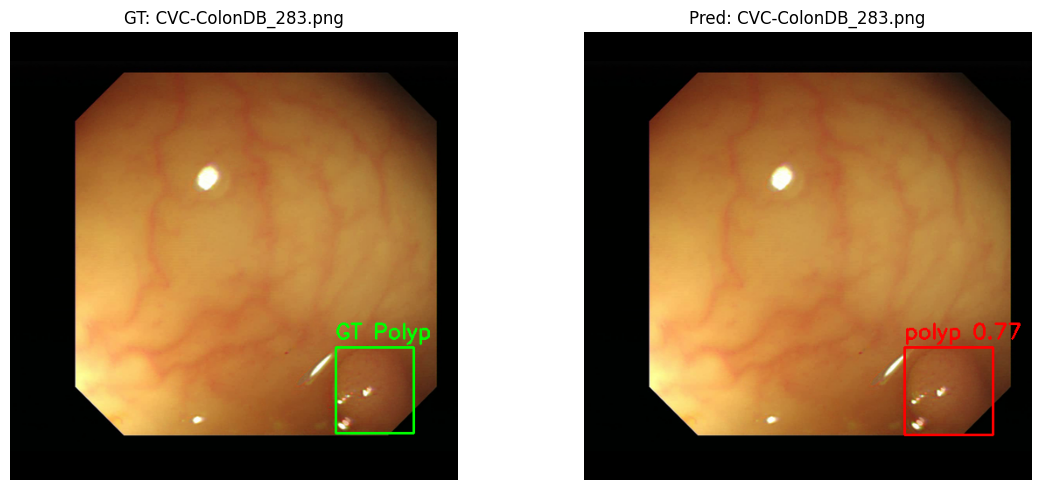

Визуализация: CVC-ClinicDB_480.png

image 1/1 /content/drive/MyDrive/Colab Notebooks/test (1)/test/images/CVC-ClinicDB_480.png: 640x640 1 polyp, 14.4ms
Speed: 3.0ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


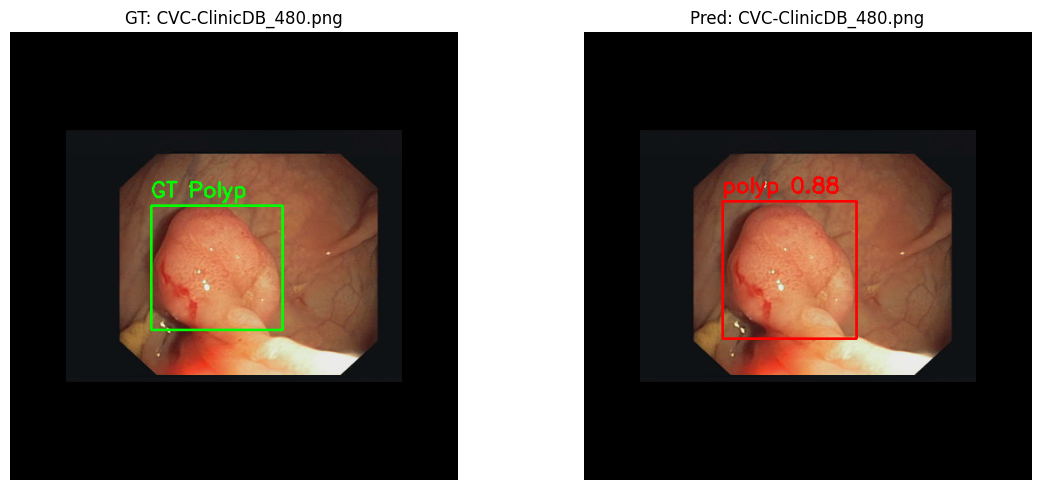

Визуализация: CVC-ClinicDB_239.png

image 1/1 /content/drive/MyDrive/Colab Notebooks/test (1)/test/images/CVC-ClinicDB_239.png: 640x640 1 polyp, 13.8ms
Speed: 4.7ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


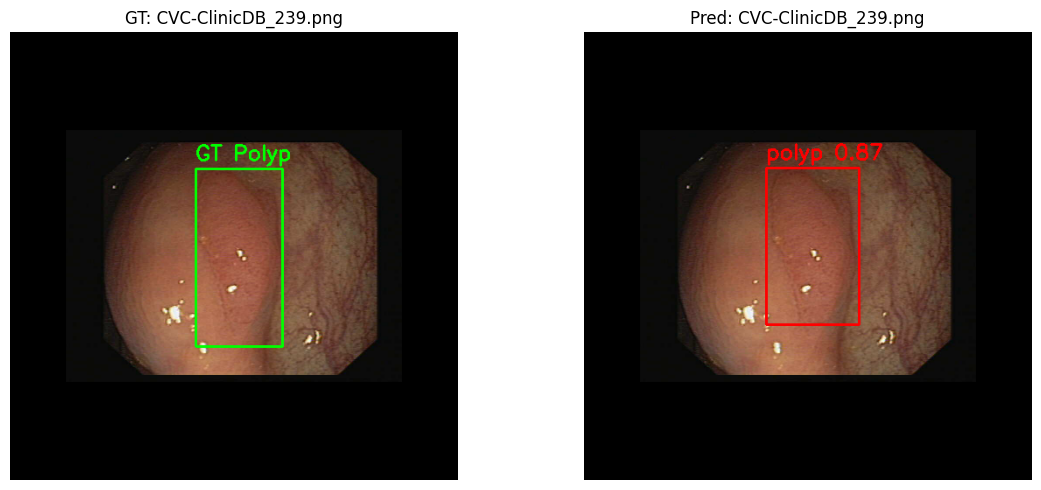

Визуализация: Kvasir-SEG_cju357rxxdaz30878y2esjpjt.png

image 1/1 /content/drive/MyDrive/Colab Notebooks/test (1)/test/images/Kvasir-SEG_cju357rxxdaz30878y2esjpjt.png: 640x640 1 polyp, 13.7ms
Speed: 3.0ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


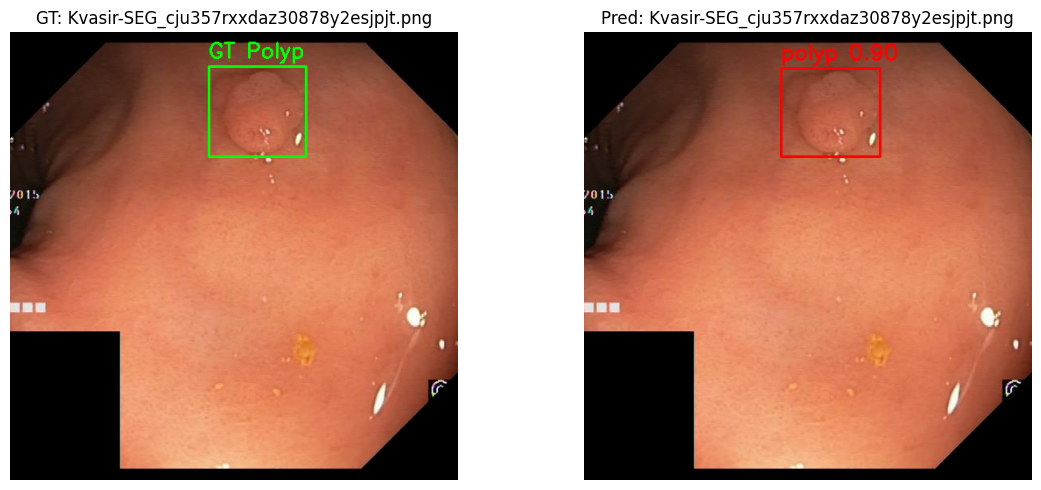

Визуализация: Kvasir-SEG_cju88evxanv9r08176zkeovec.png

image 1/1 /content/drive/MyDrive/Colab Notebooks/test (1)/test/images/Kvasir-SEG_cju88evxanv9r08176zkeovec.png: 640x640 1 polyp, 14.6ms
Speed: 3.1ms preprocess, 14.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


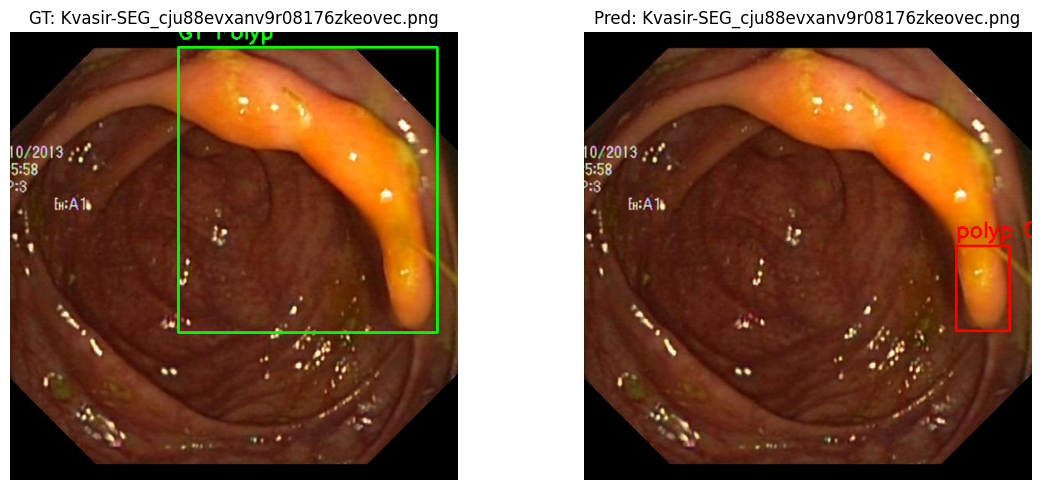

In [ ]:

%matplotlib inline

import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO


def visualize_gt_vs_pred(model, data_path, image_name, conf=0.25, iou=0.45, figsize=(12,5)):
    img_path = Path(data_path) / 'test' / 'images' / image_name
    lbl_path = Path(data_path) / 'test' / 'labels' / (Path(image_name).stem + '.txt')
    img = cv2.imread(str(img_path)); h, w = img.shape[:2]


    gt = img.copy()
    if lbl_path.exists():
        for line in open(lbl_path):
            cls, cx, cy, bw, bh = map(float, line.split())
            x1 = int((cx-bw/2)*w); y1 = int((cy-bh/2)*h)
            x2 = int((cx+bw/2)*w); y2 = int((cy+bh/2)*h)
            cv2.rectangle(gt, (x1,y1),(x2,y2),(0,255,0),2)
            cv2.putText(gt, "GT Polyp", (x1,y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0),2)
    else:
        cv2.putText(gt, "No GT", (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX,1.0,(0,255,0),2)


    res = model(str(img_path), conf=conf, iou=iou)[0]
    pred = img.copy()
    for box in res.boxes:
        x1,y1,x2,y2 = box.xyxy.cpu().int().numpy()[0]
        score = float(box.conf)
        cv2.rectangle(pred, (x1,y1),(x2,y2),(0,0,255),2)
        cv2.putText(pred, f"polyp {score:.2f}", (x1,y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255),2)


    fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)
    ax1.imshow(cv2.cvtColor(gt, cv2.COLOR_BGR2RGB))
    ax1.set_title(f"GT: {image_name}"); ax1.axis('off')
    ax2.imshow(cv2.cvtColor(pred, cv2.COLOR_BGR2RGB))
    ax2.set_title(f"Pred: {image_name}"); ax2.axis('off')
    plt.tight_layout()
    plt.show()


test_img_dir = Path(CONFIG['data_path']) / 'test' / 'images'
all_imgs = list(test_img_dir.glob('*.jpg')) + list(test_img_dir.glob('*.png'))
if len(all_imgs) < 1:
    raise RuntimeError("There are no images in the test/images folder!")


random_imgs = random.sample(all_imgs, min(5, len(all_imgs)))

model = best_model
for img_path in random_imgs:
    print("Vizualization:", img_path.name)
    visualize_gt_vs_pred(model, CONFIG['data_path'], img_path.name)


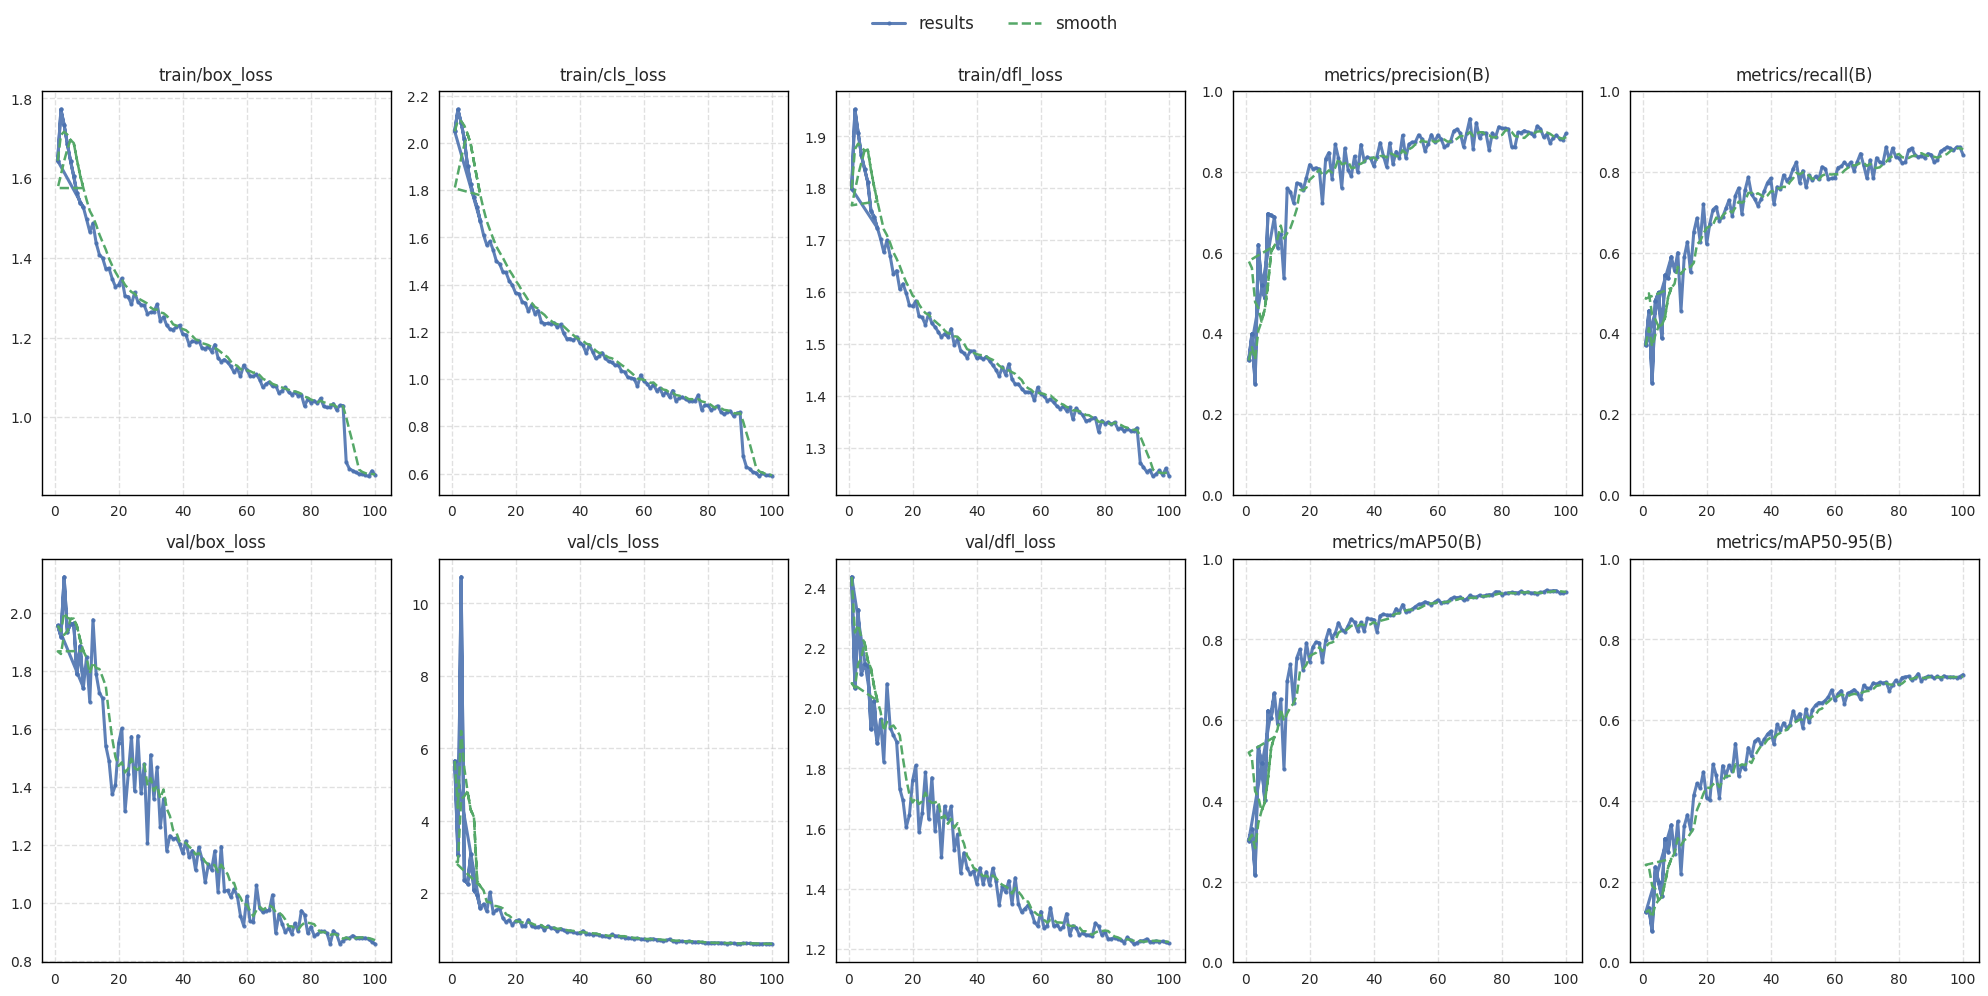

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path



results_dir = Path("colonoscopy_yolov11/yolov11_polyp_detection")
metrics_df = pd.read_csv(results_dir / "results.csv")


metrics_df["dice"] = 2 * (metrics_df["metrics/precision(B)"] * metrics_df["metrics/recall(B)"]) / \
                     (metrics_df["metrics/precision(B)"] + metrics_df["metrics/recall(B)"] + 1e-16)
metrics_df["accuracy"] = metrics_df["metrics/precision(B)"] * metrics_df["metrics/recall(B)"]


sns.set_style("whitegrid")

fig, axs = plt.subplots(2, 5, figsize=(20, 10))

def plot_with_smooth(ax, series, title):
    ax.plot(
        metrics_df["epoch"], series,
        label="results",
        linestyle="-", linewidth=2.2, alpha=0.9, marker="o", markersize=3
    )
    ax.plot(
        metrics_df["epoch"], series.rolling(window=5, min_periods=1).mean(),
        label="smooth",
        linestyle="--", linewidth=1.8
    )
    ax.set_title(title, fontsize=12, pad=8)
    ax.grid(True, linestyle="--", alpha=0.6)
    if title.startswith("metrics/"):
        ax.set_ylim(0, 1.0)


plot_with_smooth(axs[0, 0], metrics_df["train/box_loss"],       "train/box_loss")
plot_with_smooth(axs[0, 1], metrics_df["train/cls_loss"],       "train/cls_loss")
plot_with_smooth(axs[0, 2], metrics_df["train/dfl_loss"],       "train/dfl_loss")
plot_with_smooth(axs[0, 3], metrics_df["metrics/precision(B)"], "metrics/precision(B)")
plot_with_smooth(axs[0, 4], metrics_df["metrics/recall(B)"],    "metrics/recall(B)")


plot_with_smooth(axs[1, 0], metrics_df["val/box_loss"],         "val/box_loss")
plot_with_smooth(axs[1, 1], metrics_df["val/cls_loss"],         "val/cls_loss")
plot_with_smooth(axs[1, 2], metrics_df["val/dfl_loss"],         "val/dfl_loss")
plot_with_smooth(axs[1, 3], metrics_df["metrics/mAP50(B)"],     "metrics/mAP50(B)")
plot_with_smooth(axs[1, 4], metrics_df["metrics/mAP50-95(B)"],  "metrics/mAP50-95(B)")


for ax in axs.flatten():
    for side in ['top', 'right', 'bottom', 'left']:
        spine = ax.spines[side]
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color('black')


handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(results_dir / "yolov11_metric_grid_black_borders.png", dpi=300, bbox_inches="tight")
plt.show()